<a href="https://colab.research.google.com/github/prithu-anan/magic/blob/main/MAGIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

Dataset Information
Additional Information

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The data set was generated by a Monte Carlo program, Corsika, described in:
    D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
    Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

In [53]:
pd.read_csv('magic04.data')

28.7967   16.0021  2.6449  0.3918  0.1982   27.7004    22.011  \
0       31.6036   11.7235  2.5185  0.5303  0.3773   26.2722   23.8238   
1      162.0520  136.0310  4.0612  0.0374  0.0187  116.7410  -64.8580   
2       23.8172    9.5728  2.3385  0.6147  0.3922   27.2107   -6.4633   
3       75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277   28.5525   
4       51.6240   21.1502  2.9085  0.2420  0.1340   50.8761   43.1887   
...         ...       ...     ...     ...     ...       ...       ...   
19014   21.3846   10.9170  2.6161  0.5857  0.3934   15.2618   11.5245   
19015   28.9452    6.7020  2.2672  0.5351  0.2784   37.0816   13.1853   
19016   75.4455   47.5305  3.4483  0.1417  0.0549   -9.3561   41.0562   
19017  120.5135   76.9018  3.9939  0.0944  0.0683    5.8043  -93.5224   
19018  187.1814   53.0014  3.2093  0.2876  0.1539 -167.3125 -168.4558   

       -8.2027   40.092   81.8828  g  
0      -9.9574   6.3609  205.2610  g  
1     -45.2160  76.9600  256.7880  g  
2      -7.1513  10.4490  116.7370  g  
3      21.8393   4.6480  356.4620  g  
4       9.8145   3.6130  238.0980  g  
...        ...      ...       ... ..  
19014   2.8766   2.4229  106.8258  h  
19015  -2.9632  86.7975  247.4560  h  
19016  -9.4662  30.2987  256.5166  h  
19017 -63.8389  84.6874  408.3166  h  
19018  31.4755  52.7310  272.3174  h  

[19019 rows x 11 columns]

In [54]:
cols = ['fLenghth', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv('magic04.data', names = cols)

In [55]:
df['class'] = (df['class'] == 'g').astype(int)
df.head()

fLenghth    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

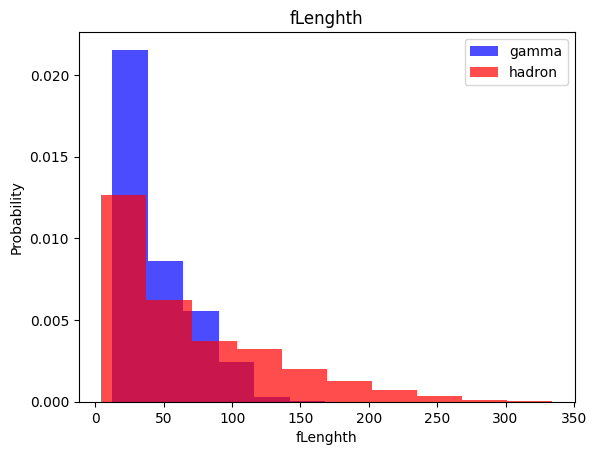

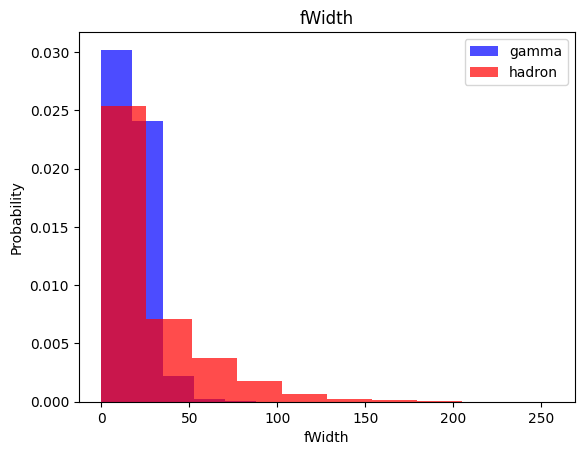

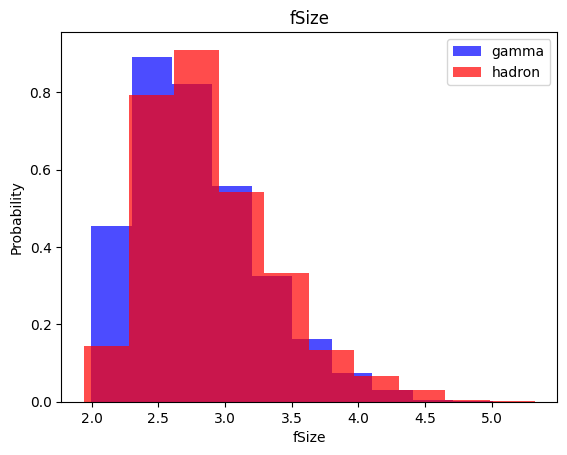

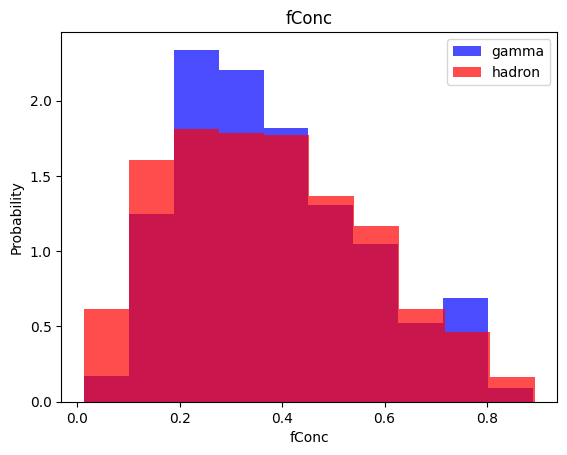

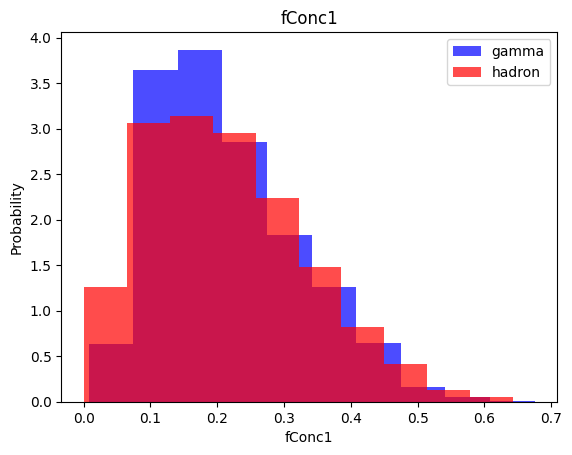

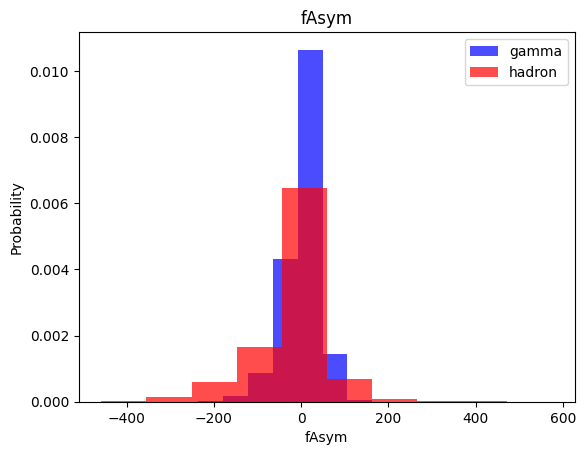

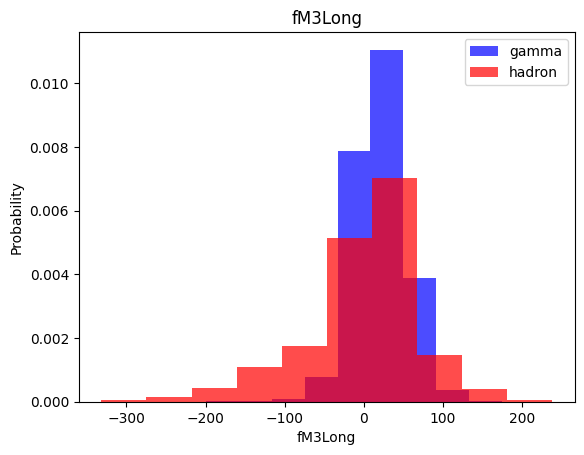

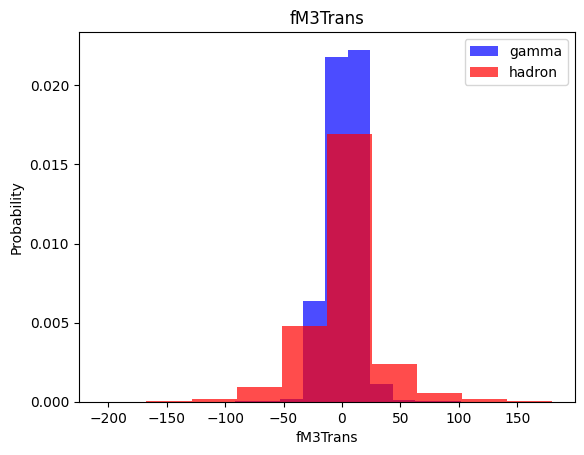

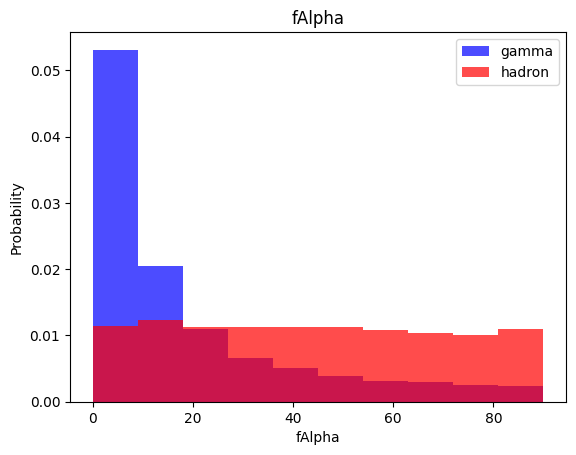

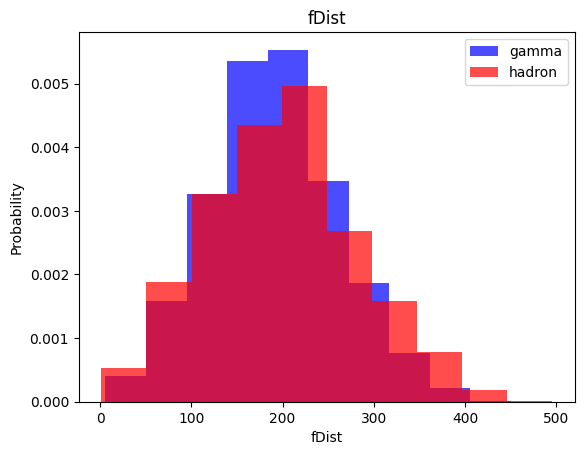

In [56]:
for label in cols[:-1]:
  plt.hist(df[df["class"]==1][label], color='blue', label='gamma', alpha=0.7, density=True)
  plt.hist(df[df["class"]==0][label], color='red', label='hadron', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

In [57]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [58]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [59]:
print(len(train[train["class"] == 1]))
print(len(train[train["class"] == 0]))

7431
3981


In [60]:
train, X_train, y_train = scale_dataset(train, True)
valid, X_valid, y_valid = scale_dataset(valid, False)
test, X_test, y_test = scale_dataset(test, False)

# kNN

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [63]:
y_pred = knn_model.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1382
           1       0.84      0.86      0.85      2422

    accuracy                           0.81      3804
   macro avg       0.80      0.79      0.80      3804
weighted avg       0.81      0.81      0.81      3804



# Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB

In [66]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [67]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.39      0.50      1382
           1       0.72      0.90      0.80      2422

    accuracy                           0.71      3804
   macro avg       0.70      0.64      0.65      3804
weighted avg       0.71      0.71      0.69      3804



# Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [70]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      1382
           1       0.83      0.82      0.83      2422

    accuracy                           0.78      3804
   macro avg       0.77      0.77      0.77      3804
weighted avg       0.79      0.78      0.78      3804



# SVM

In [71]:
from sklearn.svm import SVC

In [72]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [73]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1382
           1       0.87      0.91      0.89      2422

    accuracy                           0.86      3804
   macro avg       0.85      0.84      0.84      3804
weighted avg       0.86      0.86      0.86      3804



# Neural Net

In [74]:
import tensorflow as tf

In [82]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.show()

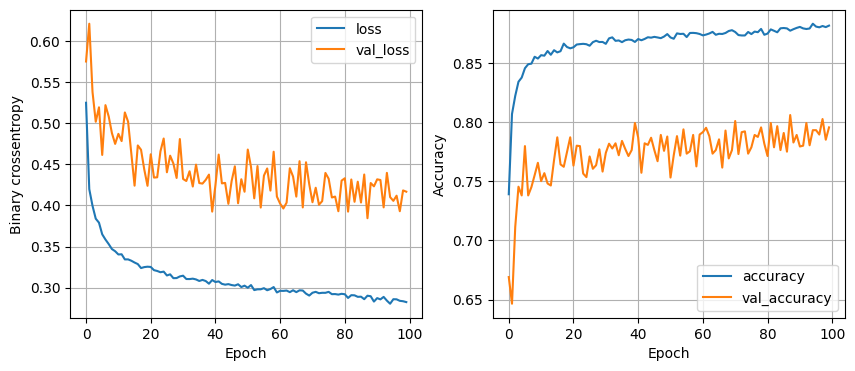

In [83]:
plot_history(history)

In [77]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history


16 nodes, dropout 0, lr 0.01, batch size 32


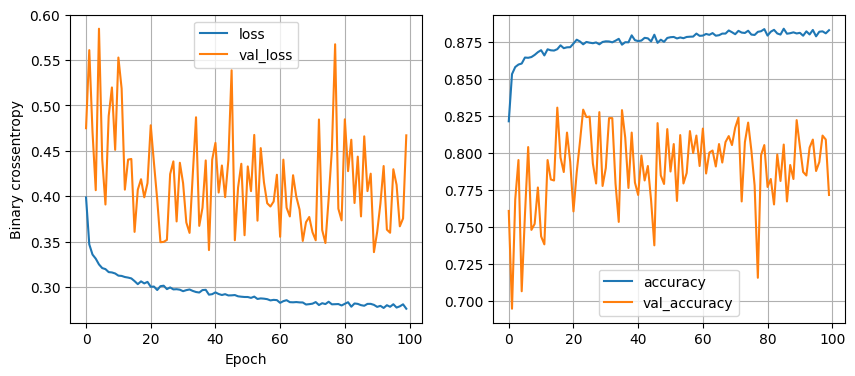

119/119 [==============================] - 0s 2ms/step - loss: 0.3187 - accuracy: 0.8757
16 nodes, dropout 0, lr 0.01, batch size 64


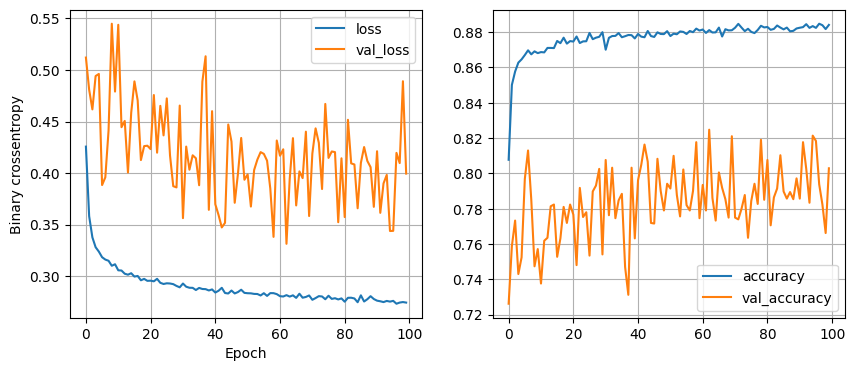

119/119 [==============================] - 0s 2ms/step - loss: 0.3180 - accuracy: 0.8736
16 nodes, dropout 0, lr 0.01, batch size 128


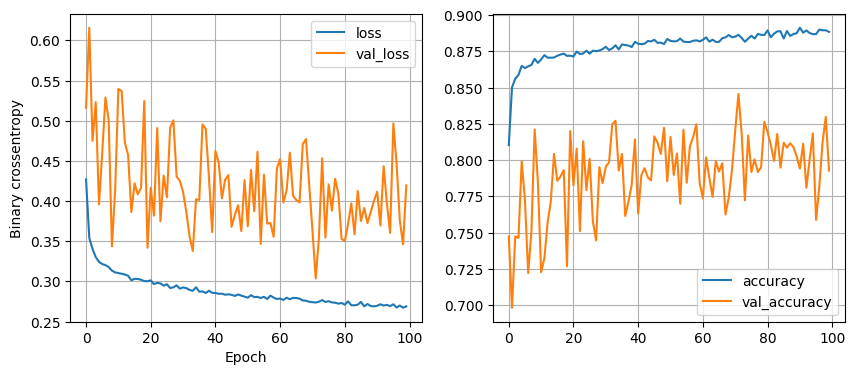

119/119 [==============================] - 0s 2ms/step - loss: 0.2980 - accuracy: 0.8883
16 nodes, dropout 0, lr 0.005, batch size 32


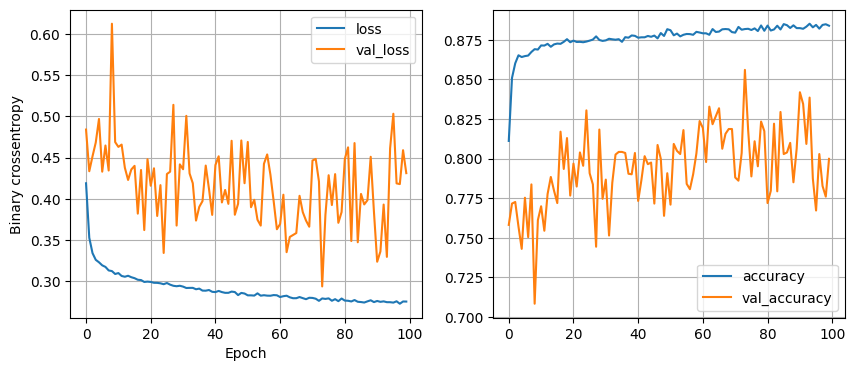

119/119 [==============================] - 0s 3ms/step - loss: 0.3058 - accuracy: 0.8817
16 nodes, dropout 0, lr 0.005, batch size 64


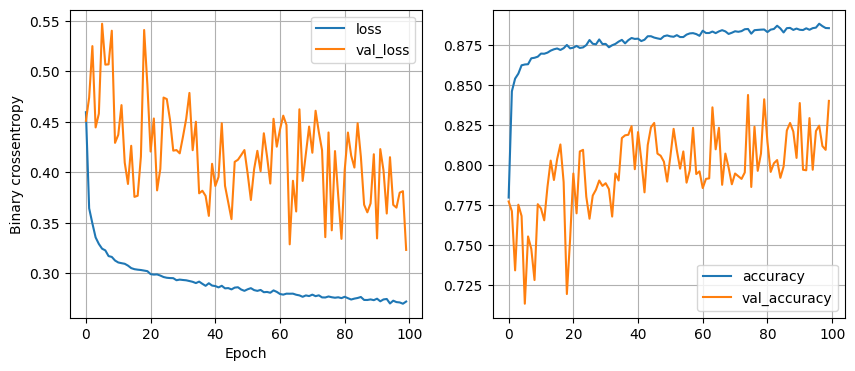

119/119 [==============================] - 0s 3ms/step - loss: 0.3234 - accuracy: 0.8672
16 nodes, dropout 0, lr 0.005, batch size 128


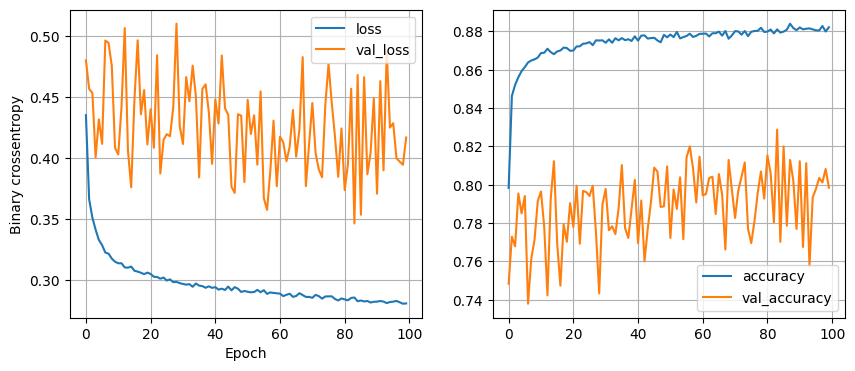

119/119 [==============================] - 0s 2ms/step - loss: 0.3042 - accuracy: 0.8783
16 nodes, dropout 0, lr 0.001, batch size 32


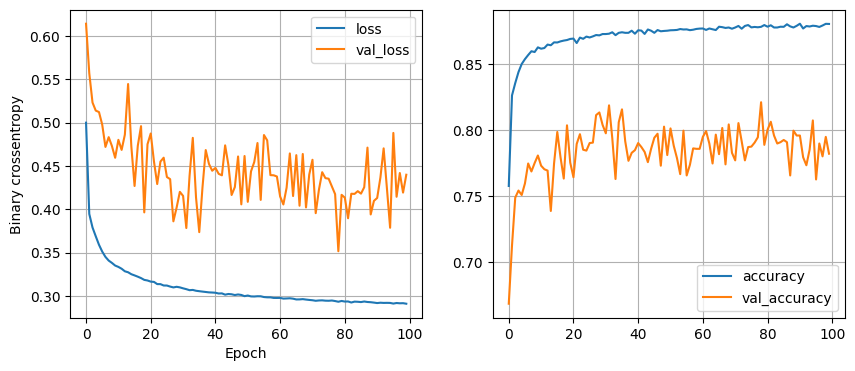

119/119 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8764
16 nodes, dropout 0, lr 0.001, batch size 64


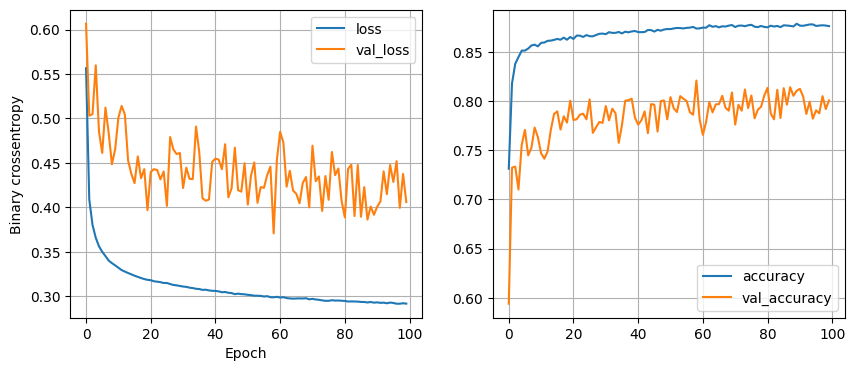

119/119 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.8770
16 nodes, dropout 0, lr 0.001, batch size 128


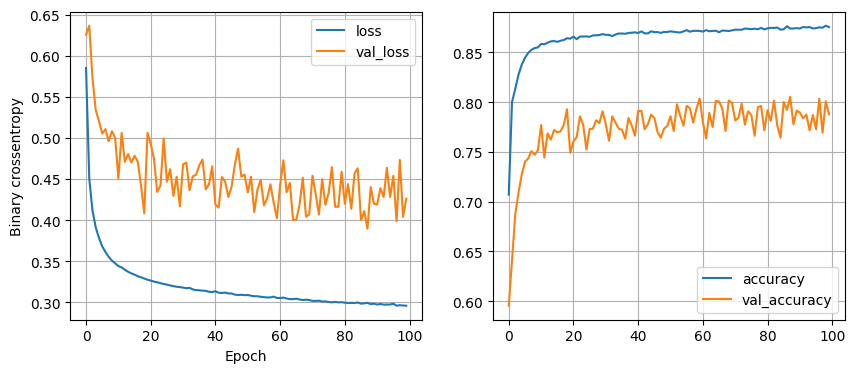

119/119 [==============================] - 0s 3ms/step - loss: 0.3056 - accuracy: 0.8767
16 nodes, dropout 0.2, lr 0.01, batch size 32


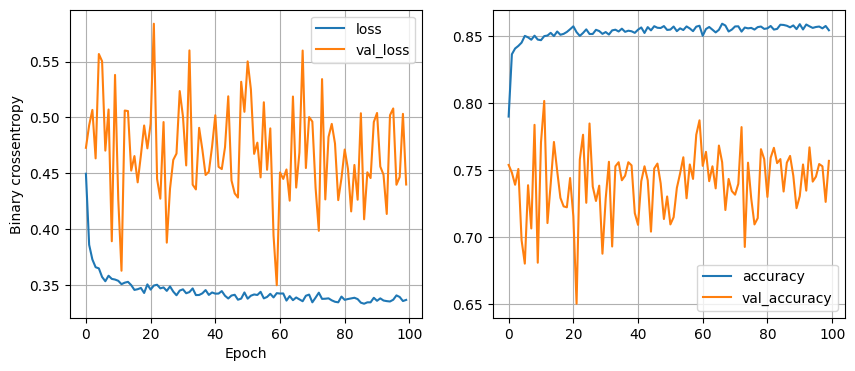

119/119 [==============================] - 0s 2ms/step - loss: 0.3127 - accuracy: 0.8707
16 nodes, dropout 0.2, lr 0.01, batch size 64


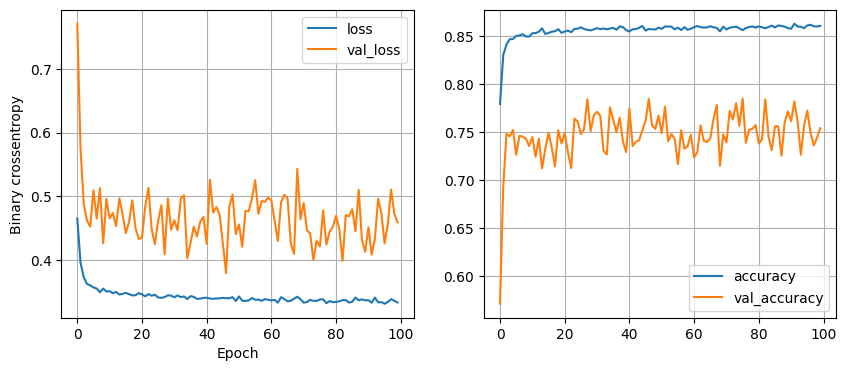

119/119 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8801
16 nodes, dropout 0.2, lr 0.01, batch size 128


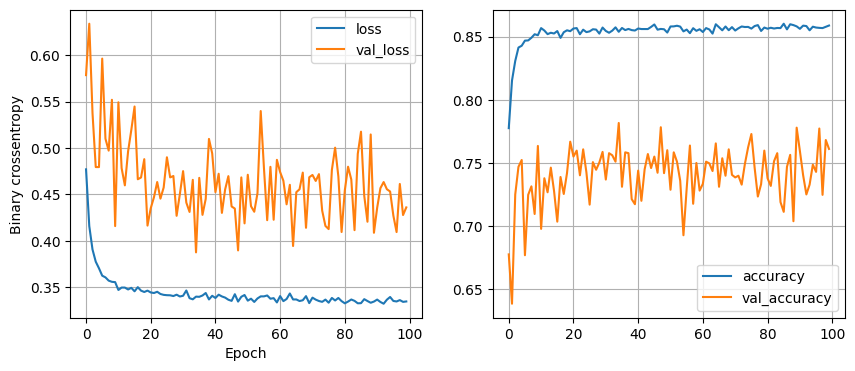

119/119 [==============================] - 0s 2ms/step - loss: 0.3111 - accuracy: 0.8730
16 nodes, dropout 0.2, lr 0.005, batch size 32


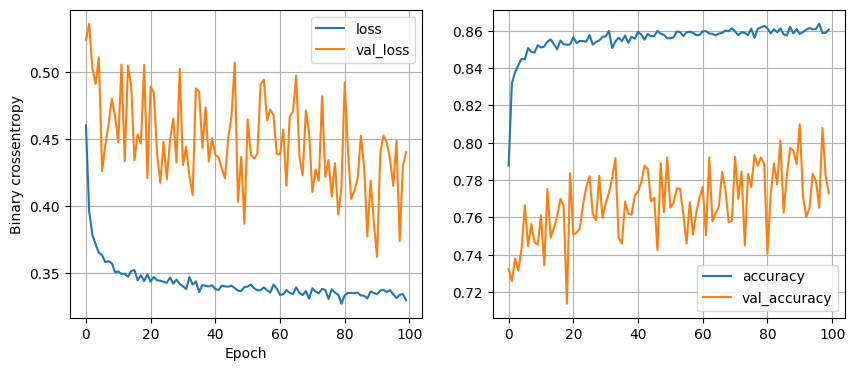

119/119 [==============================] - 0s 2ms/step - loss: 0.3024 - accuracy: 0.8793
16 nodes, dropout 0.2, lr 0.005, batch size 64


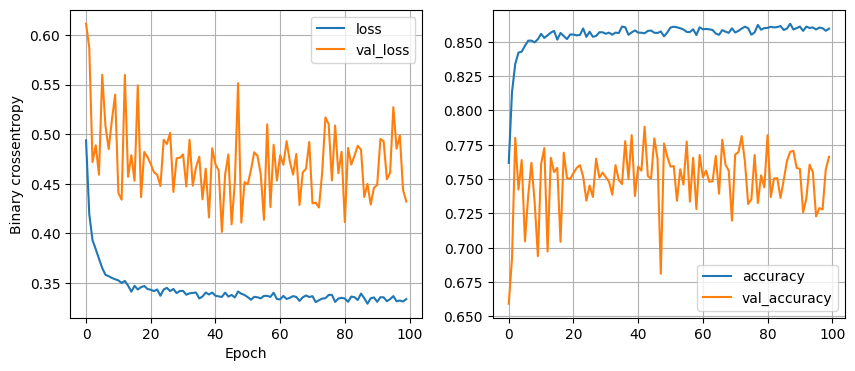

119/119 [==============================] - 0s 2ms/step - loss: 0.3144 - accuracy: 0.8730
16 nodes, dropout 0.2, lr 0.005, batch size 128


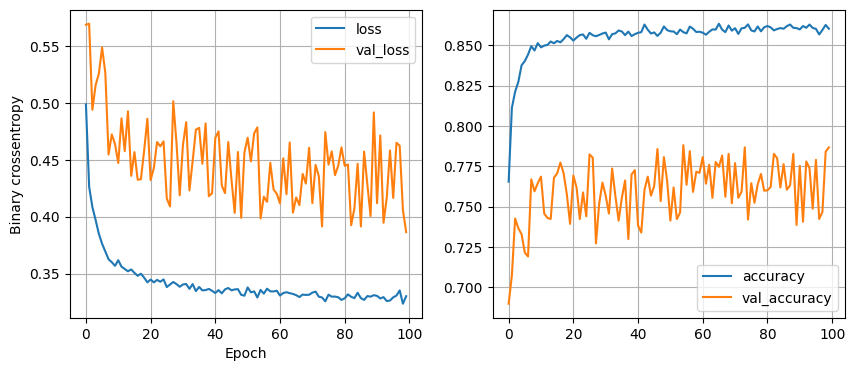

119/119 [==============================] - 0s 2ms/step - loss: 0.3144 - accuracy: 0.8764
16 nodes, dropout 0.2, lr 0.001, batch size 32


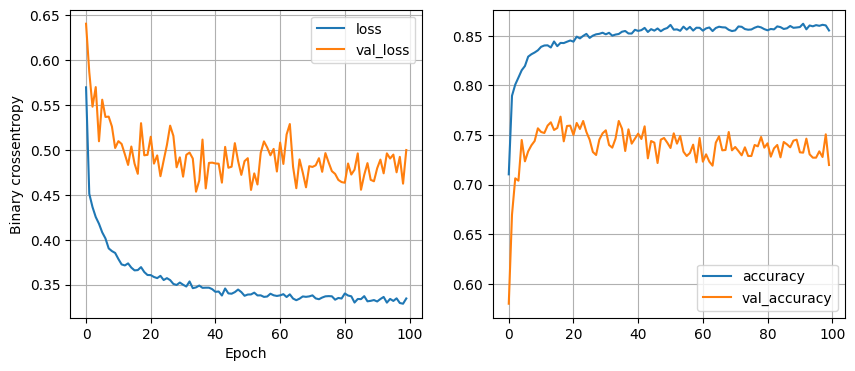

119/119 [==============================] - 0s 2ms/step - loss: 0.3065 - accuracy: 0.8707
16 nodes, dropout 0.2, lr 0.001, batch size 64


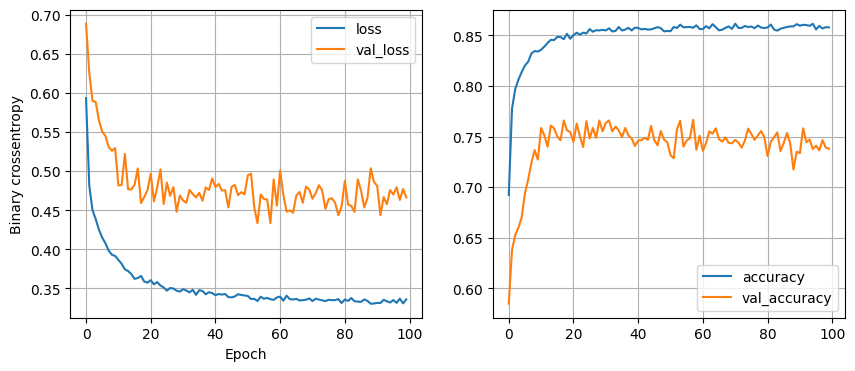

119/119 [==============================] - 0s 2ms/step - loss: 0.3077 - accuracy: 0.8764
16 nodes, dropout 0.2, lr 0.001, batch size 128


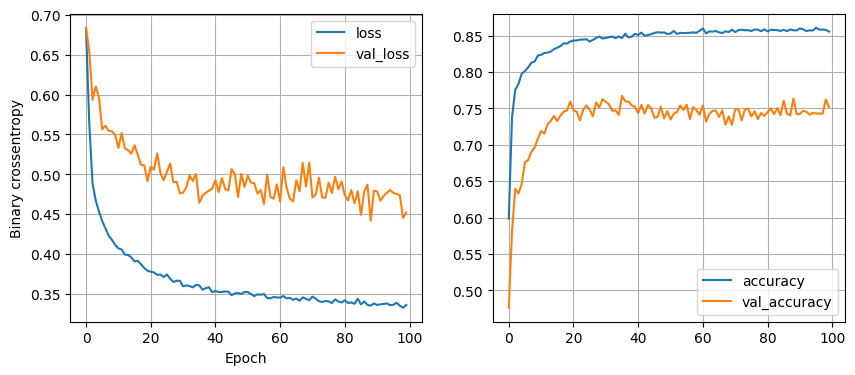

119/119 [==============================] - 0s 2ms/step - loss: 0.3106 - accuracy: 0.8725
32 nodes, dropout 0, lr 0.01, batch size 32


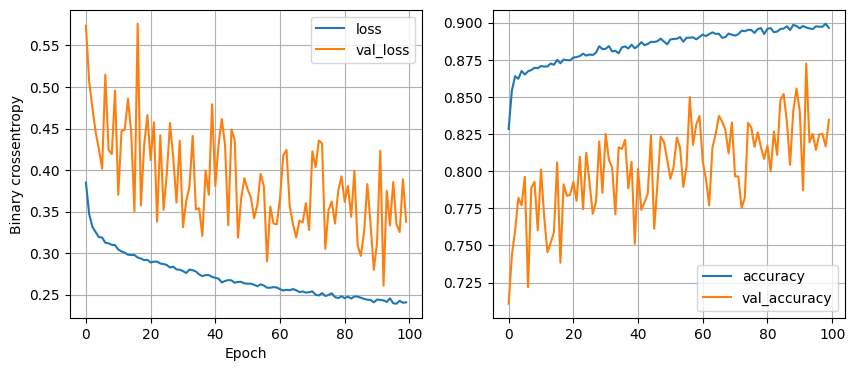

119/119 [==============================] - 0s 2ms/step - loss: 0.3793 - accuracy: 0.8693
32 nodes, dropout 0, lr 0.01, batch size 64


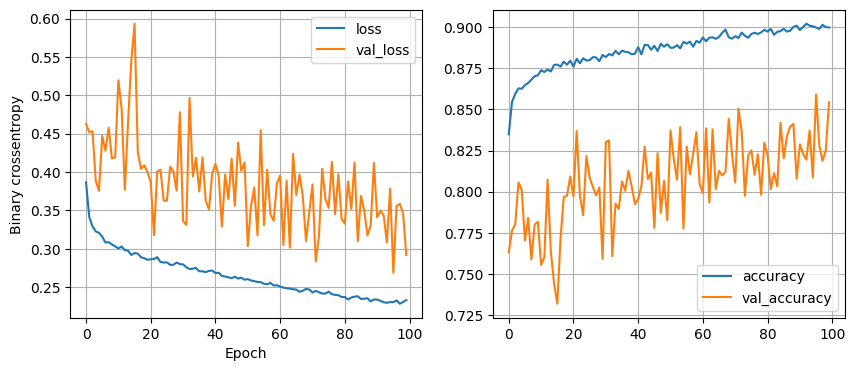

119/119 [==============================] - 0s 4ms/step - loss: 0.3929 - accuracy: 0.8720
32 nodes, dropout 0, lr 0.01, batch size 128


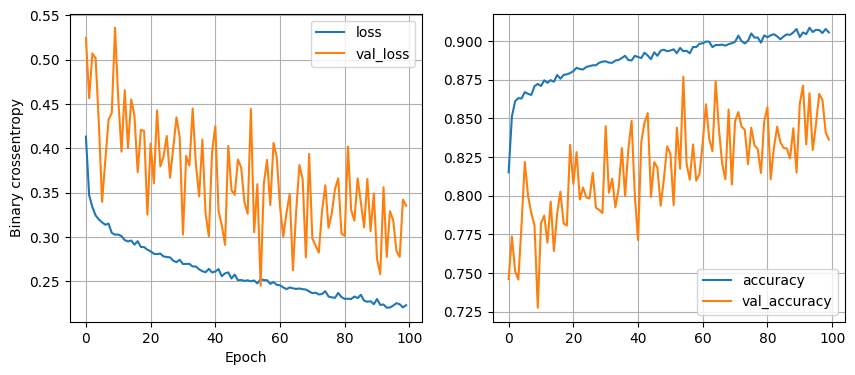

119/119 [==============================] - 0s 3ms/step - loss: 0.3655 - accuracy: 0.8730
32 nodes, dropout 0, lr 0.005, batch size 32


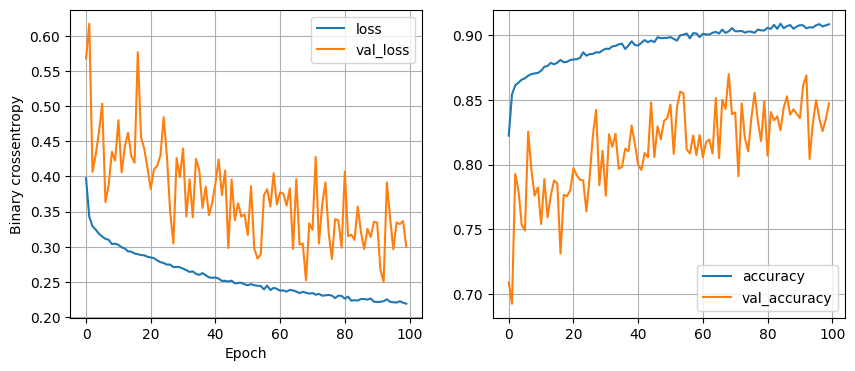

119/119 [==============================] - 0s 3ms/step - loss: 0.3907 - accuracy: 0.8620
32 nodes, dropout 0, lr 0.005, batch size 64


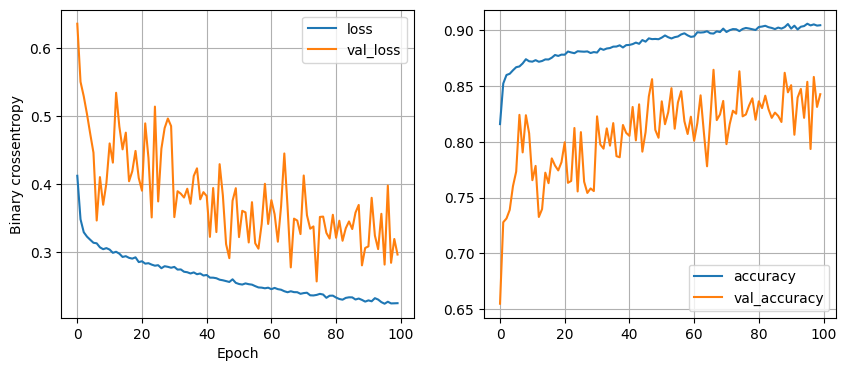

119/119 [==============================] - 0s 3ms/step - loss: 0.3314 - accuracy: 0.8728
32 nodes, dropout 0, lr 0.005, batch size 128


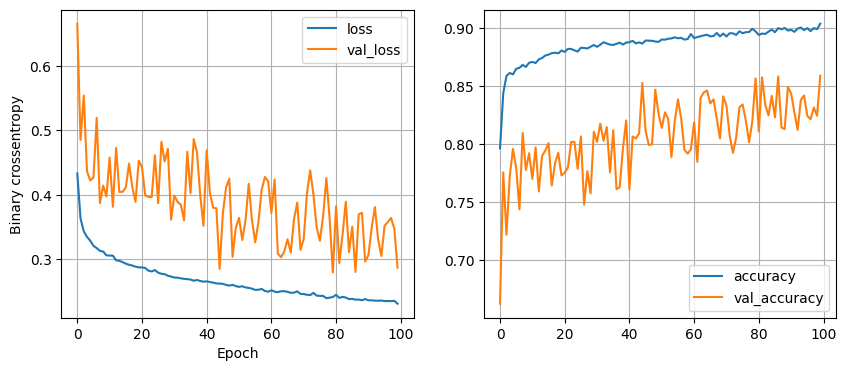

119/119 [==============================] - 0s 3ms/step - loss: 0.3373 - accuracy: 0.8659
32 nodes, dropout 0, lr 0.001, batch size 32


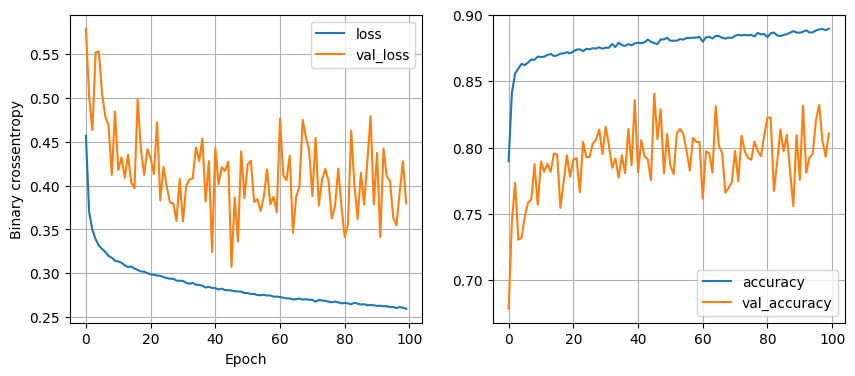

119/119 [==============================] - 0s 3ms/step - loss: 0.3093 - accuracy: 0.8746
32 nodes, dropout 0, lr 0.001, batch size 64


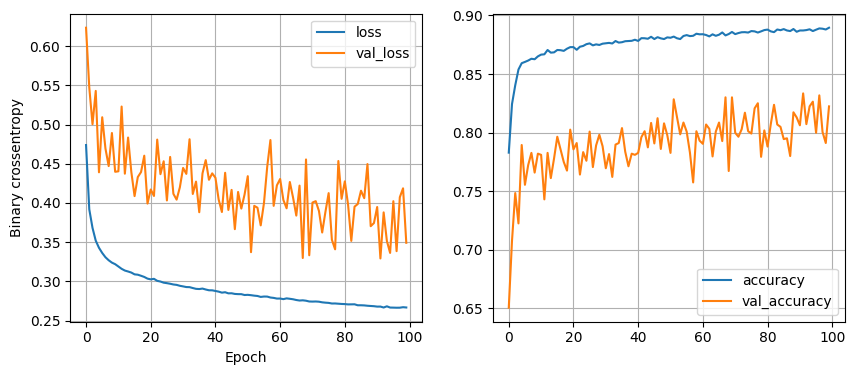

119/119 [==============================] - 0s 4ms/step - loss: 0.3106 - accuracy: 0.8770
32 nodes, dropout 0, lr 0.001, batch size 128


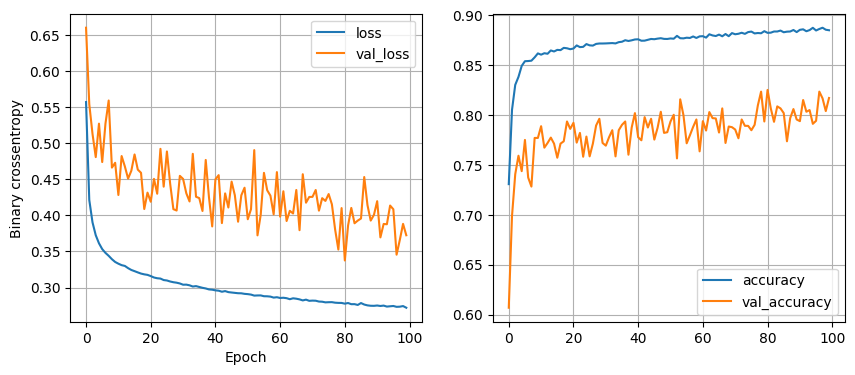

119/119 [==============================] - 0s 2ms/step - loss: 0.3083 - accuracy: 0.8785
32 nodes, dropout 0.2, lr 0.01, batch size 32


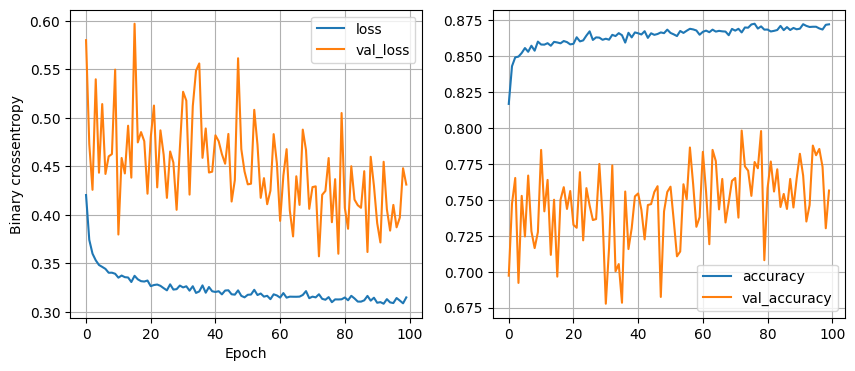

119/119 [==============================] - 0s 2ms/step - loss: 0.2998 - accuracy: 0.8801
32 nodes, dropout 0.2, lr 0.01, batch size 64


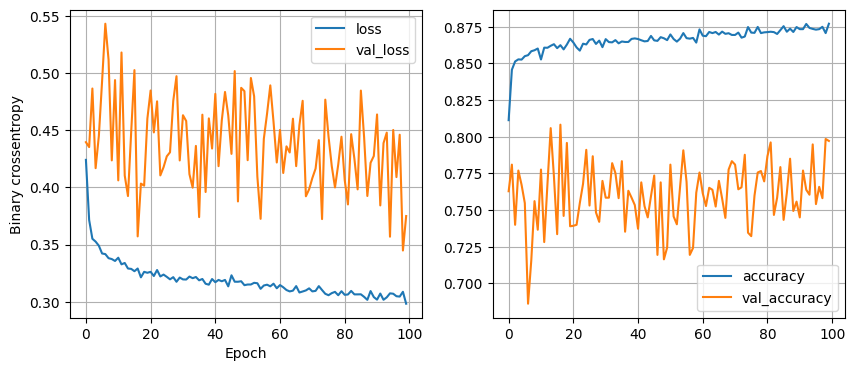

119/119 [==============================] - 0s 3ms/step - loss: 0.3002 - accuracy: 0.8775
32 nodes, dropout 0.2, lr 0.01, batch size 128


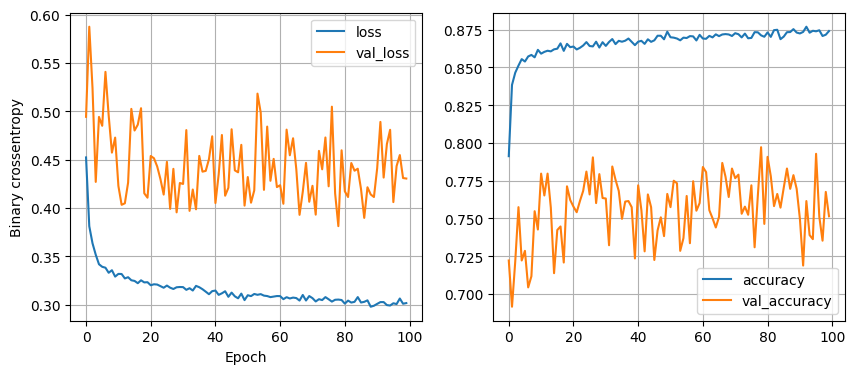

119/119 [==============================] - 0s 4ms/step - loss: 0.2953 - accuracy: 0.8807
32 nodes, dropout 0.2, lr 0.005, batch size 32


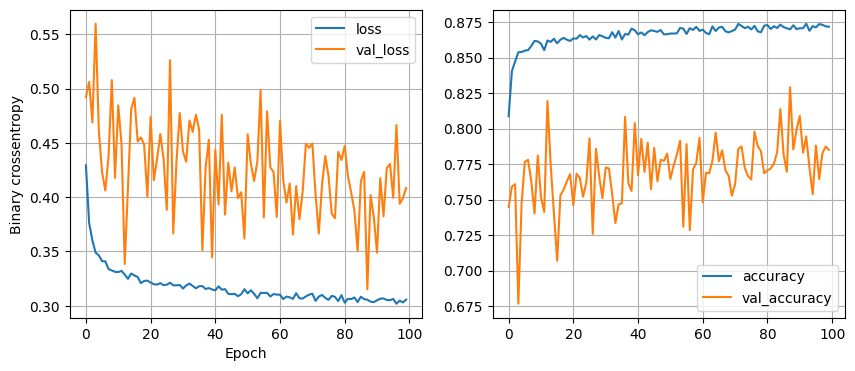

119/119 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.8841
32 nodes, dropout 0.2, lr 0.005, batch size 64


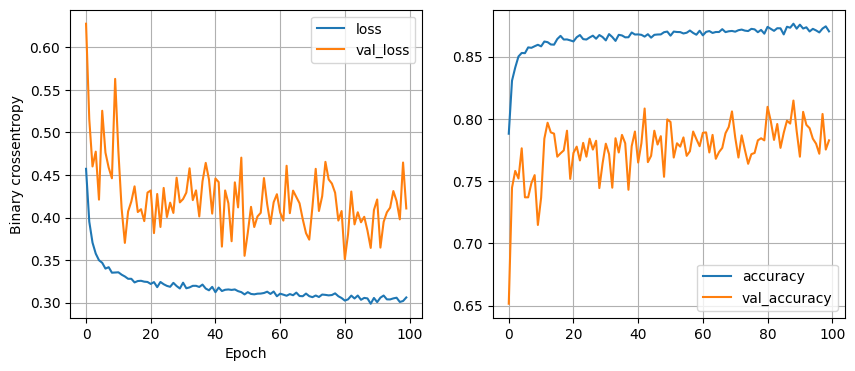

119/119 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.8835
32 nodes, dropout 0.2, lr 0.005, batch size 128


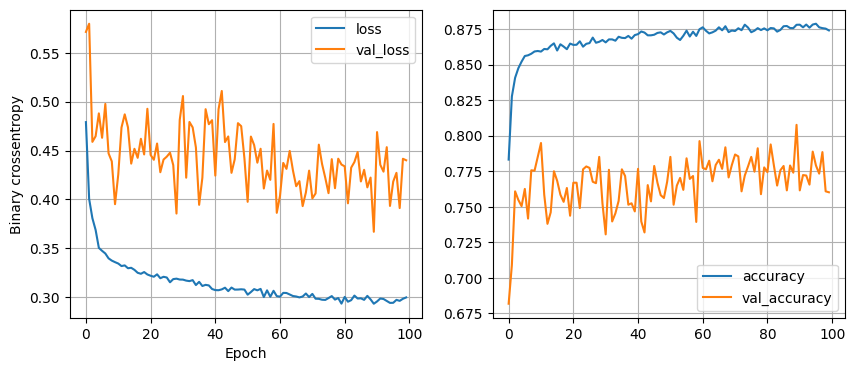

119/119 [==============================] - 0s 3ms/step - loss: 0.2914 - accuracy: 0.8867
32 nodes, dropout 0.2, lr 0.001, batch size 32


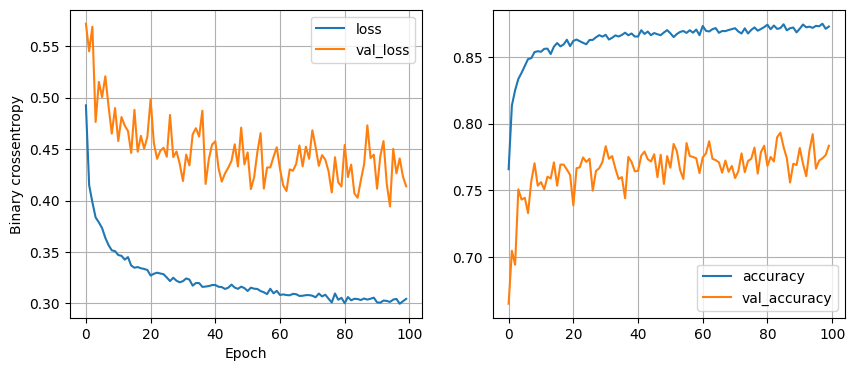

119/119 [==============================] - 0s 2ms/step - loss: 0.2888 - accuracy: 0.8843
32 nodes, dropout 0.2, lr 0.001, batch size 64


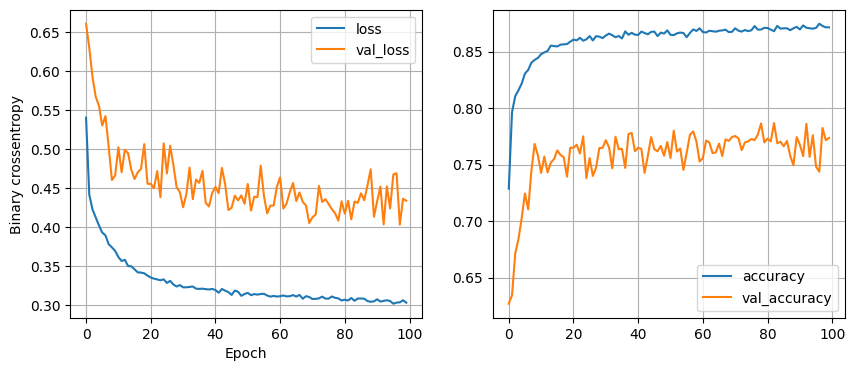

119/119 [==============================] - 0s 3ms/step - loss: 0.2935 - accuracy: 0.8820
32 nodes, dropout 0.2, lr 0.001, batch size 128


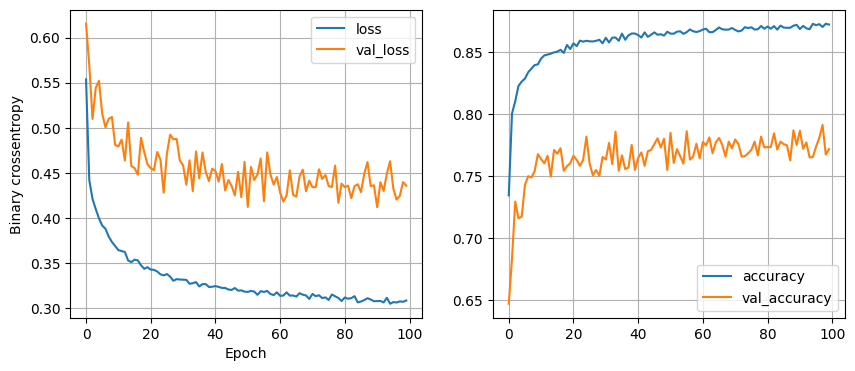

119/119 [==============================] - 0s 3ms/step - loss: 0.2939 - accuracy: 0.8775
64 nodes, dropout 0, lr 0.01, batch size 32


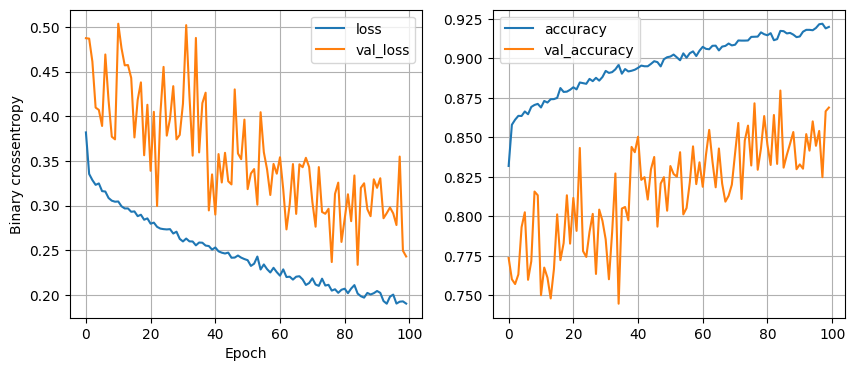

119/119 [==============================] - 0s 3ms/step - loss: 0.4945 - accuracy: 0.8707
64 nodes, dropout 0, lr 0.01, batch size 64


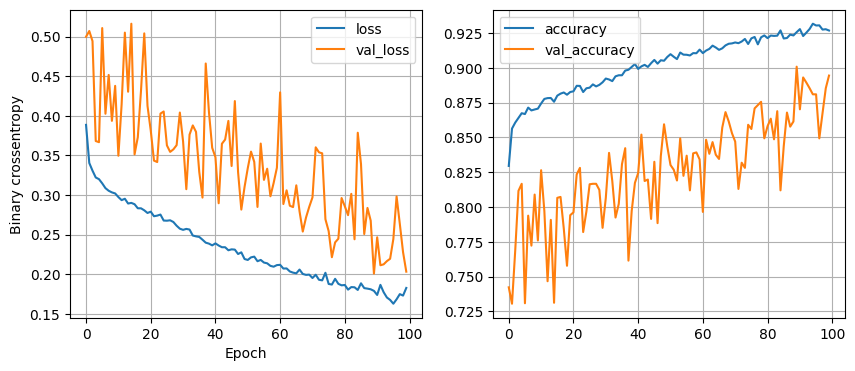

119/119 [==============================] - 0s 3ms/step - loss: 0.5404 - accuracy: 0.8649
64 nodes, dropout 0, lr 0.01, batch size 128


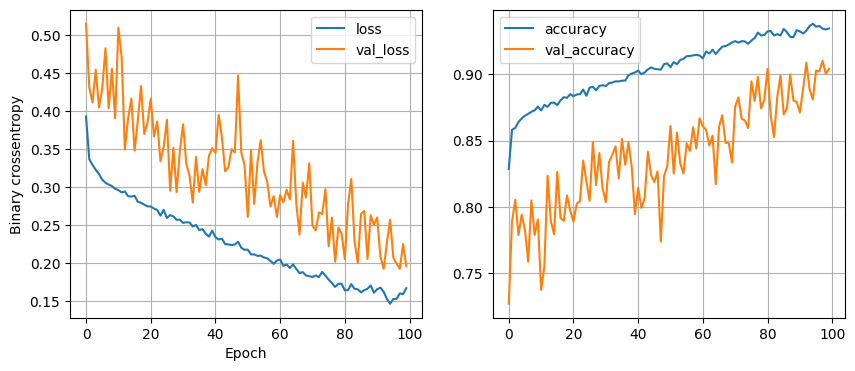

119/119 [==============================] - 0s 4ms/step - loss: 0.4737 - accuracy: 0.8633
64 nodes, dropout 0, lr 0.005, batch size 32


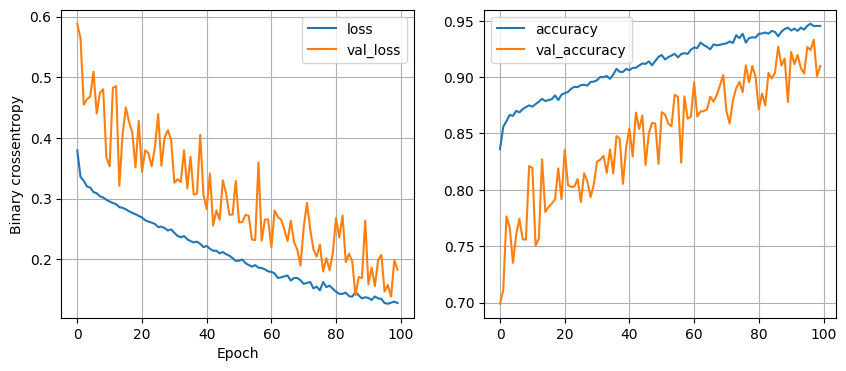

119/119 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.8599
64 nodes, dropout 0, lr 0.005, batch size 64


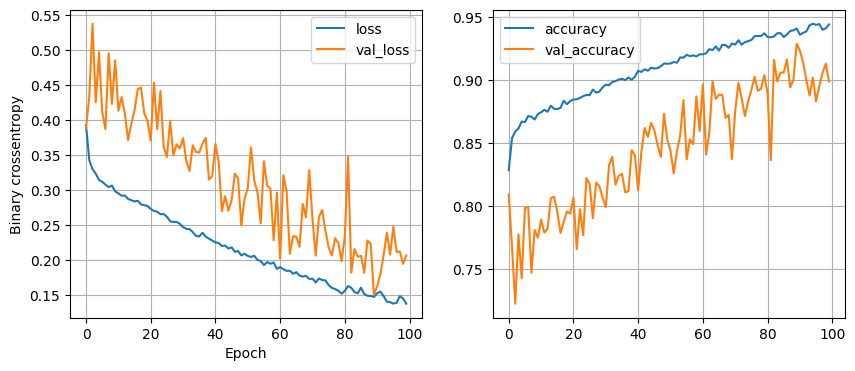

119/119 [==============================] - 0s 3ms/step - loss: 0.5414 - accuracy: 0.8604
64 nodes, dropout 0, lr 0.005, batch size 128


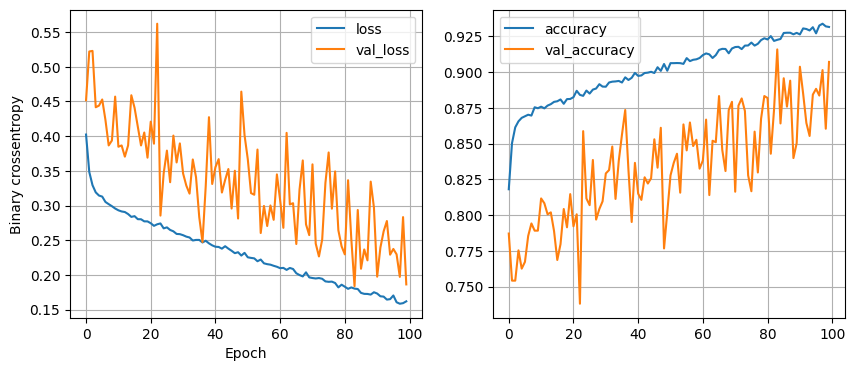

119/119 [==============================] - 0s 3ms/step - loss: 0.4518 - accuracy: 0.8601
64 nodes, dropout 0, lr 0.001, batch size 32


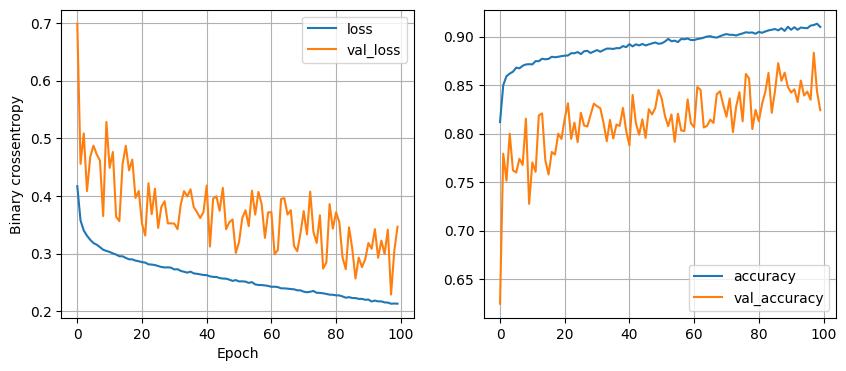

119/119 [==============================] - 0s 3ms/step - loss: 0.3484 - accuracy: 0.8743
64 nodes, dropout 0, lr 0.001, batch size 64


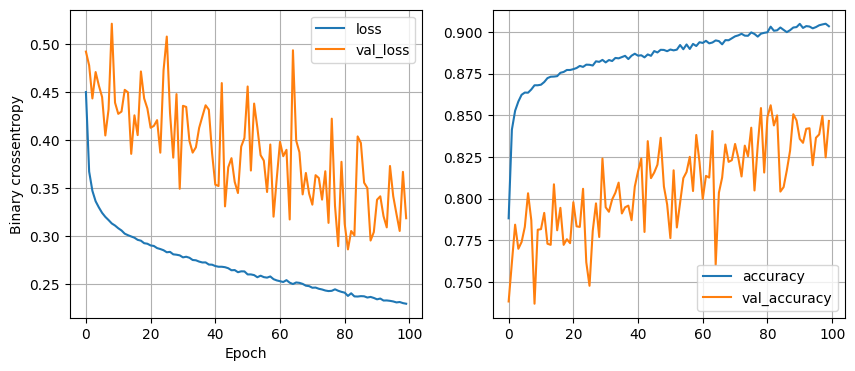

119/119 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8725
64 nodes, dropout 0, lr 0.001, batch size 128


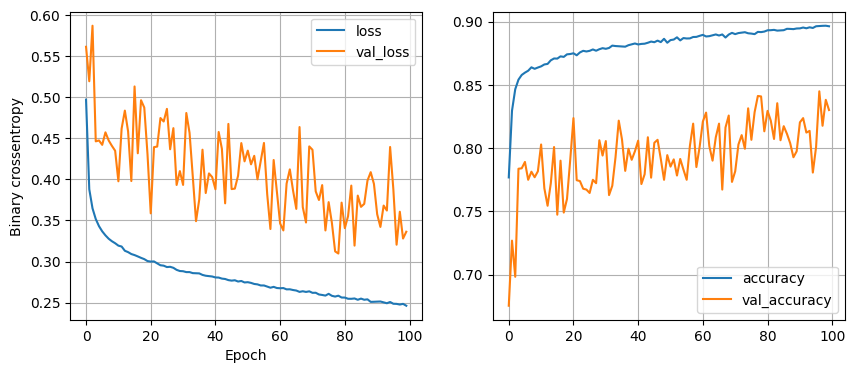

119/119 [==============================] - 0s 3ms/step - loss: 0.3111 - accuracy: 0.8785
64 nodes, dropout 0.2, lr 0.01, batch size 32


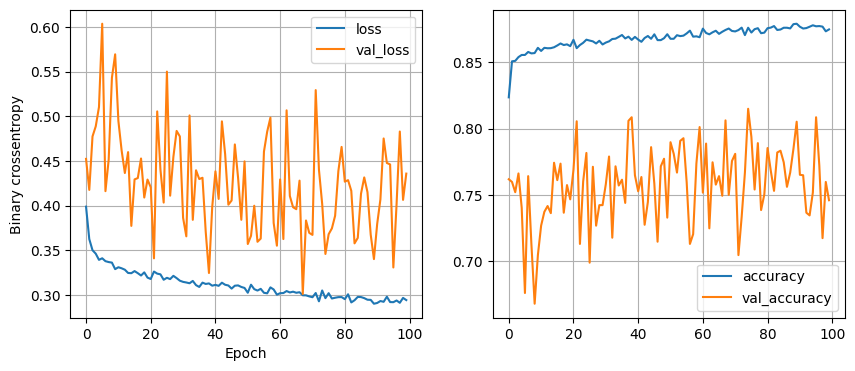

119/119 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.8762
64 nodes, dropout 0.2, lr 0.01, batch size 64


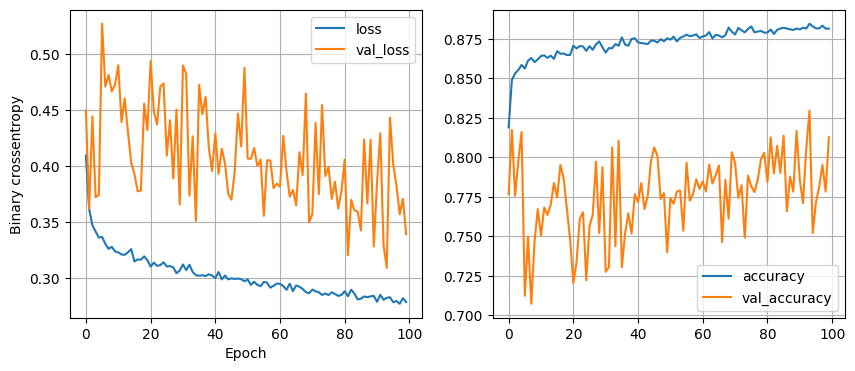

119/119 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8788
64 nodes, dropout 0.2, lr 0.01, batch size 128


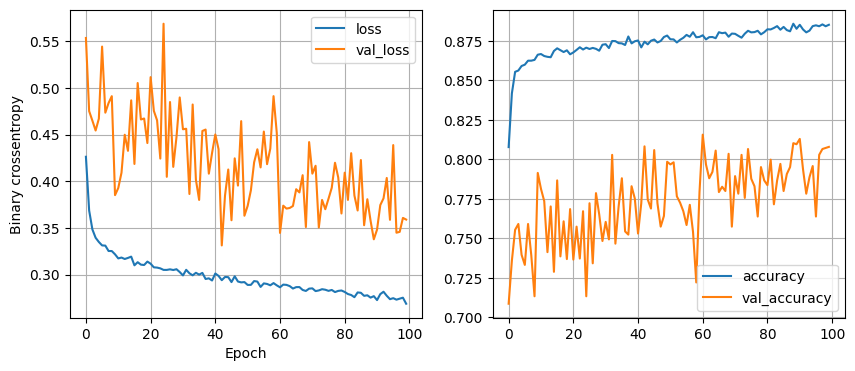

119/119 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.8785
64 nodes, dropout 0.2, lr 0.005, batch size 32


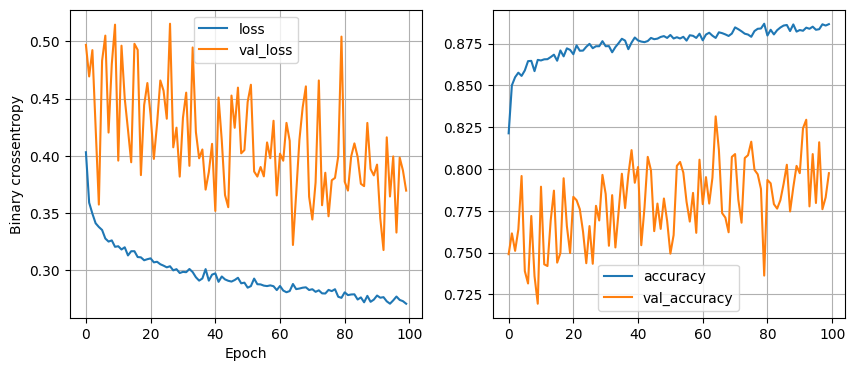

119/119 [==============================] - 0s 3ms/step - loss: 0.2976 - accuracy: 0.8807
64 nodes, dropout 0.2, lr 0.005, batch size 64


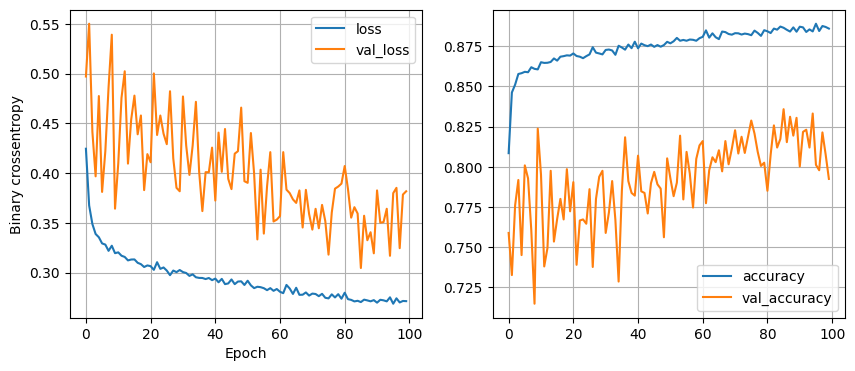

119/119 [==============================] - 0s 3ms/step - loss: 0.2929 - accuracy: 0.8849
64 nodes, dropout 0.2, lr 0.005, batch size 128


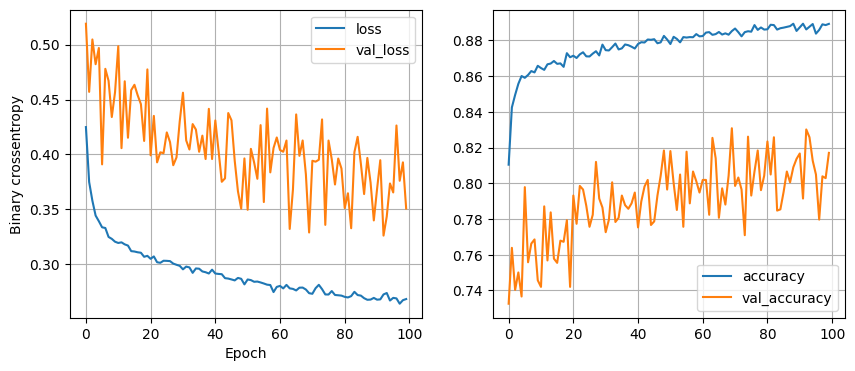

119/119 [==============================] - 0s 2ms/step - loss: 0.2958 - accuracy: 0.8841
64 nodes, dropout 0.2, lr 0.001, batch size 32


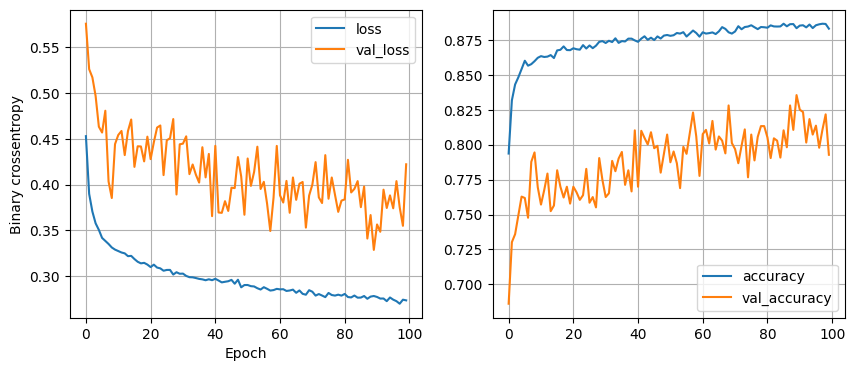

119/119 [==============================] - 0s 3ms/step - loss: 0.2911 - accuracy: 0.8846
64 nodes, dropout 0.2, lr 0.001, batch size 64


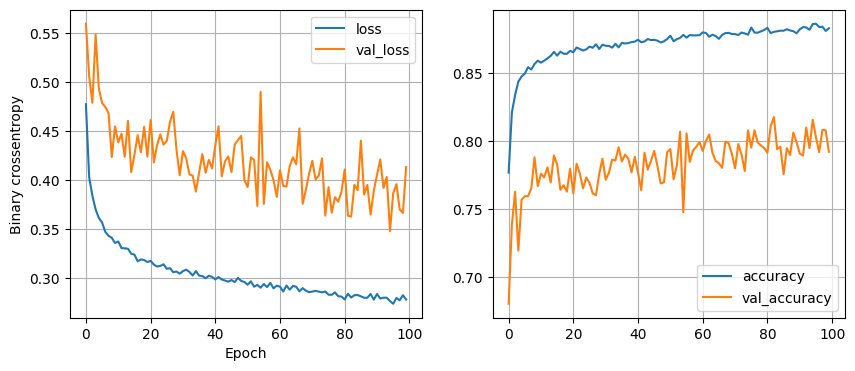

119/119 [==============================] - 0s 3ms/step - loss: 0.2848 - accuracy: 0.8833
64 nodes, dropout 0.2, lr 0.001, batch size 128


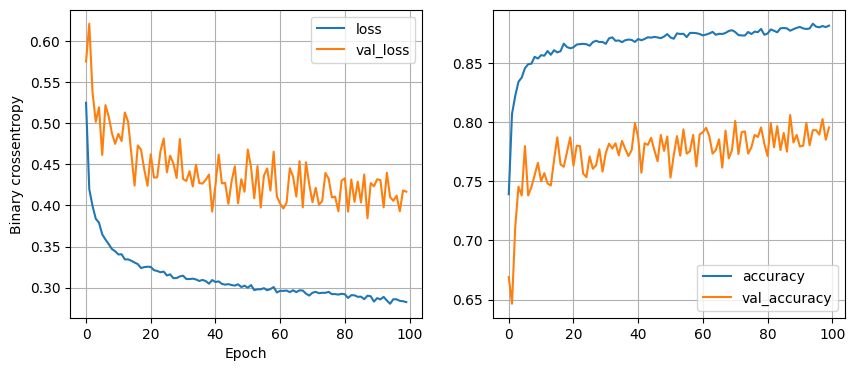

119/119 [==============================] - 0s 3ms/step - loss: 0.2892 - accuracy: 0.8801


In [81]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)
        if val_loss[0] < least_val_loss:
          least_val_loss = val_loss[0]
          least_loss_model = model